In [61]:
# Load libriaries and functions.
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
# Define helper functions.
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [65]:
#Training and testing on C2+C3
NS_case1 = pd.read_excel("NS_EOS_Case1.xlsx")
NS_case2 = pd.read_excel("NS_EOS_Case2.xlsx")
NS_case3 = pd.read_excel("NS_EOS_Case3.xlsx")
NS = pd.concat([NS_case2,NS_case3],ignore_index=True)
X = NS.iloc[:, 0:7].values
y = NS.iloc[:, [7,9,11]].values

In [66]:
columns = NS_case2.columns[0:8].tolist() + [NS_case2.columns[9]]+ [NS_case2.columns[11]]
inputs = columns[0:7]
outputs = columns[7:]

## Preprocessing
The data is quite messy and has to be preprocessed first. We will focus on the inputs and outputs which were measured for most of the time (one sensor died quite early). Data is scaled after removing rows with missing values. Afterwards, outliers are detected and removed using an Isolation Forest.

In [68]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
sc_y = StandardScaler()
y = sc_y.fit_transform(y)
X_t = np.hstack((X,y))
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)

In [69]:
dataset

,e(0),rho(0),K(0),Q(0),J(0),L(0),Ksym(0),NS mass,R14,Lambda14
0,-0.414747,-2.563707,1.940126,0.830094,-1.301915,-0.082711,-0.850796,-2.333596,0.448521,0.008563
1,-1.390824,-0.085593,3.117088,0.293295,-1.070268,-0.197467,-1.114236,-2.365787,-0.054689,-0.383045
2,-0.285088,1.138167,-1.950281,2.532391,1.407779,1.621897,2.924565,-1.288461,-4.280704,-3.131814
3,3.793110,-1.095195,-1.768451,1.625406,-0.861081,2.819353,2.861728,-0.945090,2.558167,2.885653
4,-1.289642,1.168761,-2.358041,2.524679,-0.482247,1.608749,2.443426,-1.749865,0.672108,0.974248
...,...,...,...,...,...,...,...,...,...,...
4780,0.013006,0.342723,-0.034059,0.043226,0.977048,-1.787312,-1.408961,-0.731556,-1.758908,-1.440686
4781,0.013612,-0.116187,-0.033987,0.043232,1.536141,-1.361960,-1.027163,0.176230,-1.128634,-0.949154
4782,0.011189,-0.177375,-0.033908,0.043193,1.493111,-1.790466,-1.500397,-0.584551,-1.681437,-1.397515
4783,0.014218,0.006189,-0.033948,0.043213,1.987805,-1.475961,-1.207794,0.033517,-1.293943,-1.093398


In [70]:
# Define some hyperparameters.
n_epochs = 15
n_samples = dataset.shape[0]
n_batches = 32
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples

# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])

# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)

# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

## Model Building
### Aleotoric Uncertainty
To account for aleotoric uncertainty, which arises from the noise in the output, dense layers are combined with probabilistic layers. More specifically, the mean and covariance matrix of the output is modelled as a function of the input and parameter weights. The first hidden layer shall consist of 10 nodes, the second one needs 3 nodes for the means plus ten nodes for the variances and covariances of the 3-dimensional (there are 3 outputs) multivariate Gaussian posterior probability distribution in the final layer. This is achieved using the params_size method of the last layer (MultivariateNormalTriL), which is the declaration of the posterior probability distribution structure, in this case a multivariate normal distribution in which only one half of the covariance matrix is estimated (due to symmetry). The total number of parameters in the model is 179 — estimated by variational methods. The deterministic version of this neural network consists of an input layer, ten latent variables (hidden nodes), and an output layer (114 parameters), which does not include the uncertainty in the parameters weights.

In [71]:
# Define prior for regularization.
len_inputs = 7
len_outputs = 3
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len_outputs, dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)
# Define model instance.
model = tfk.Sequential([tfk.layers.InputLayer(input_shape=(len_inputs,), name="input"),
                        tfk.layers.Dense(10, activation="relu", name="dense_1"),
                        tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(len_outputs), activation=None, 
                                         name="distribution_weights"),
                        tfp.layers.MultivariateNormalTriL(len_outputs, 
                                                          activity_regularizer=
                                                          tfp.layers.KLDivergenceRegularizer(prior,weight=1/n_batches)
                                  , name="output")]
                       , name="model")
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=True)
# Describe model.
model.summary()

Epoch 1/15
345/345 [==============================] - 19s 54ms/step - loss: 33.1508 - val_loss: 11.4557
Epoch 2/15
345/345 [==============================] - 18s 54ms/step - loss: 8.5976 - val_loss: 7.0536
Epoch 3/15
345/345 [==============================] - 18s 53ms/step - loss: 6.1890 - val_loss: 5.5525
Epoch 4/15
345/345 [==============================] - 20s 57ms/step - loss: 5.1300 - val_loss: 4.6583
Epoch 5/15
345/345 [==============================] - 19s 54ms/step - loss: 4.4921 - val_loss: 4.2662
Epoch 6/15
345/345 [==============================] - 18s 53ms/step - loss: 4.0589 - val_loss: 3.8985
Epoch 7/15
345/345 [==============================] - 18s 53ms/step - loss: 3.7634 - val_loss: 3.6330
Epoch 8/15
345/345 [==============================] - 18s 53ms/step - loss: 3.5399 - val_loss: 3.4443
Epoch 9/15
345/345 [==============================] - 18s 53ms/step - loss: 3.3809 - val_loss: 3.3402
Epoch 10/15
345/345 [==============================] - 19s 56ms/step - loss: 3.2

dict_keys(['loss', 'val_loss'])


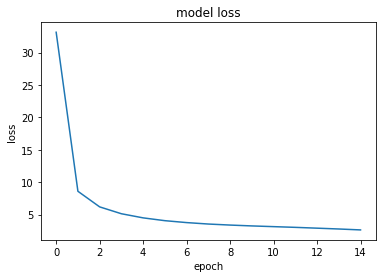

In [72]:
import matplotlib.pyplot as plt
print(model.history.history.keys())
# "Loss"
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

The activity_regularizer argument acts as prior for the output layer (the weight has to be adjusted to the number of batches). The training session might take a while depending on the specifications of your machine.

## Aleotoric and Epistemic Uncertainty
To account for aleotoric and epistemic uncertainty (uncertainty in parameter weights), the dense layers have to be exchanged with Flipout layers (DenseFlipout). Such a model has 424 parameters, since every weight is parametrized by normal distribution with non-shared mean and standard deviation, hence doubling the amount of parameter weights. Weights will be resampled for different predictions, and in that case, the Bayesian neural network will act like an ensemble.

tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

The default prior distribution over weights is tfd.Normal(loc=0., scale=1.) and can be adjusted using the kernel_prior_fn argument.

## Prediction
Since it is a probabilistic model, a Monte Carlo experiment is performed to provide a prediction. In particular, every prediction of a sample x results in a different output y, which is why the expectation over many individual predictions has to be calculated. Additionally, the variance can be determined this way.

In [79]:
# Predict.

samples = 200
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true = np.empty(shape=(samples, len_inputs))
Y_true = np.empty(shape=(samples, len_outputs))
Y_pred = np.empty(shape=(samples, len_outputs, iterations))

for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    X_true[i,:] = sc_X.inverse_transform(X_true[i,:])
    Y_true[i,:] = labels.numpy()
    Y_true[i,:] = sc_y.inverse_transform(Y_true[i,:])
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        Y_pred[i,:,k] = sc_y.inverse_transform(Y_pred[i,:,k])

# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

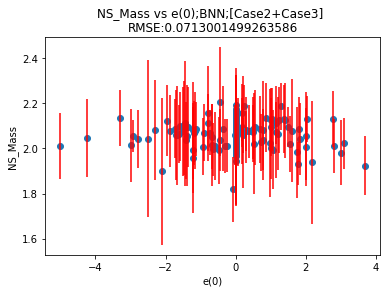

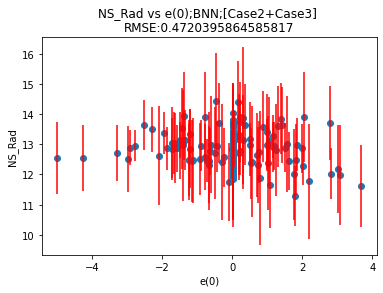

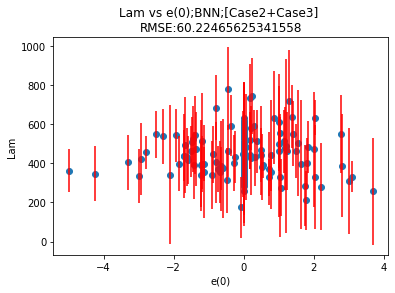

In [80]:
import sklearn.metrics
#plot of values and error bars
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    rms = 'RMSE:'+str((np.sqrt(sklearn.metrics.mean_squared_error(Y_true[:,i], Y_pred_m[:,i]))))
    fig, ax = plt.subplots()
    ax.scatter(X_true[:,0],Y_pred_m[:,i])
    ax.errorbar(X_true[:,0],Y_pred_m[:,i],yerr=2*Y_pred_s[:,i],ecolor='red',linestyle="None")
    ax.set_ylabel(titles[i])
    ax.set_xlabel('e(0)')
    plt.title(titles[i]+' vs e(0);BNN;[Case2+Case3] \n'+rms)
    plt.show()

In [81]:
#RMS value
rms = sklearn.metrics.mean_squared_error(Y_true, Y_pred_m)**0.5
rms_mass = sklearn.metrics.mean_squared_error(Y_true[:,0], Y_pred_m[:,0])**0.5
rms_rad = sklearn.metrics.mean_squared_error(Y_true[:,1], Y_pred_m[:,1])**0.5
rms_lam = sklearn.metrics.mean_squared_error(Y_true[:,2], Y_pred_m[:,2])**0.5

#R2 value
r2 = sklearn.metrics.r2_score(Y_true,Y_pred_m)

result_new = pd.DataFrame(columns=['Model','RMS','RMS_NS_Mass','RMS_NS_Rad','RMS_Lam','R2'])

result_new = result_new.append({'Model':'BNN', 'RMS':rms,'RMS_NS_Mass':rms_mass,'RMS_NS_Rad':rms_rad,
                        'RMS_Lam':rms_lam, 'R2':r2}, ignore_index=True)

result_new

,Model,RMS,RMS_NS_Mass,RMS_NS_Rad,RMS_Lam,R2
0,BNN,34.771814,0.0713,0.47204,60.224656,0.570312


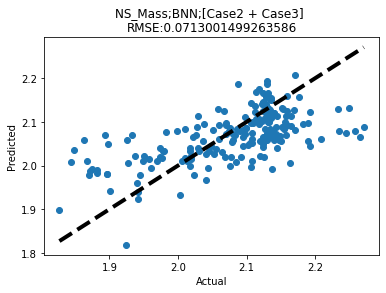

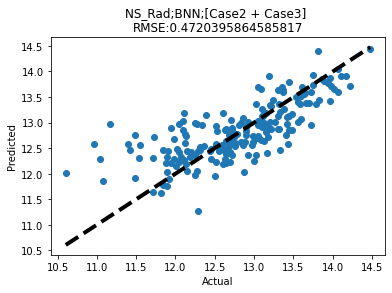

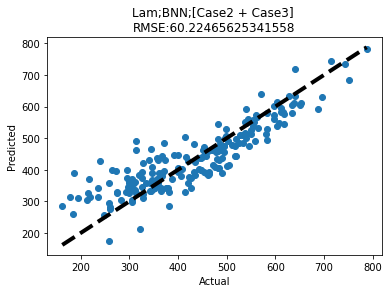

In [82]:
#Plotting
titles = ['NS_Mass','NS_Rad','Lam']
for i in range(3):
    rms = 'RMSE:'+str((np.sqrt(sklearn.metrics.mean_squared_error(Y_true[:,i], Y_pred_m[:,i]))))
    fig, ax = plt.subplots()
    ax.scatter(Y_true[:,i], Y_pred_m[:,i])
    ax.plot([Y_true[:,i].min(), Y_true[:,i].max()], [Y_true[:,i].min(), Y_true[:,i].max()], 'k--', lw=4)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    plt.title(titles[i]+';BNN;[Case2 + Case3] \n'+rms)
    plt.show()